In [384]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import urllib #for capture the xml data from expert sender api
from datetime import datetime, timedelta
from scipy import stats #for the independence t-test
import pymongo #connect to mongodb
from pymongo import MongoClient
from datetime import datetime
from pandas.io.json import json_normalize #convert json to dataframe from mongodb
from xml2dict import xml2dict #convert xml to dictionary structure
import requests
from dateutil.parser import parse

## Get data from ExpertSender API

In [385]:
def getdata(typedata, campaignID):
    
    #Get the send date of campaign from API
    api2 = 'https://api6.esv2.com/v2/Api/Messages/'
    api2_url = api2 + campaignID + '?apiKey=PVrtTPJeKjBYuJ5UgCWr'
    response = requests.get(api2_url)
    xmlDict = xml2dict(response.text)
    SendDate = xmlDict['ApiResponse']['Data']['SentDate']
    start = datetime.strptime(SendDate, '%Y-%m-%dT%H:%M:%S.%f')
    
    date_generated = [start + timedelta(days=x) for x in range(0, 10)] #Limit the range to 10 days after campaign
    listdf = list()
    
    #Get data
    for date in date_generated:
        date = date.strftime("%Y-%m-%d")    
        api_url = 'https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr'
        csv_url = api_url + '&date=' + date + '&type=' + typedata
        print(csv_url)
        dfget = pd.read_csv(csv_url)
        dfget = dfget[dfget.MessageId == int(campaignID)]
        dfget = dfget[['Date', 'Email']] #Filter view
        dfget = dfget.rename(columns={'Date':'date', 'Email':'email'}) #Rename
        listdf.append(dfget) #Concanate mutiple df to list
        
    #Cleaning dataframe
    df = pd.concat(listdf, ignore_index = True)
    df = df.drop_duplicates(subset=['email']) #Drop dupplicate clicks by Email
    return df

In [402]:
#Connect to Galaxy stored in MongoDB

def addcolumn(dfinput):
    client = MongoClient('13.251.20.59', 27017)
    db = client.galaxy
    email_collection = db.emails
    email_send_list = list(dfinput['email'])
    df2 = pd.DataFrame()
    #Use chunked loading (separate the list) in case we have large list need to fetch with data inside MongoDB

    for i in range(0, len(email_send_list), 20000):
        datapoints = email_collection.find( {'email': {'$in': email_send_list[i:i + 20000] } } ) 
        df2 = pd.concat([df2, json_normalize(datapoints)], sort=False)
    df2 = df2[['email', 'dob', 'gender']]
    dfinput = pd.merge(dfinput, df2, how='left', on='email')

    return dfinput

In [404]:
#Convert birthday to right format

def convert_dob_to_age(dfinput):
    dfinput['dob'] = pd.to_datetime(dfinput['dob'])
    dfinput['age'] = ((datetime.now() - dfinput['dob'])/365).dt.days
    dfinput = dfinput.drop(columns = 'dob').fillna(dfinput.mean())
    return dfinput

#### For now, we choose Campaign ID (1194), List Type (Recipients, Clickers)

In [386]:
#Clickers list

dfClicks = getdata("Clicks", "1194")
dfClicks.info()
dfClicks.head()

https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-16&type=Clicks
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-17&type=Clicks
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-18&type=Clicks
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-19&type=Clicks
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-20&type=Clicks
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-21&type=Clicks
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-22&type=Clicks
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-23&type=Clicks
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-24&type=Clicks
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-25&type=Clicks
<class 'pandas.core.frame.DataFrame'>
Int64Index: 236 entries, 0 to 36

,date,email
0,2019-03-16 16:52:00,mbakolabolumbu@cg93.fr
3,2019-03-16 16:54:00,f.duval763@laposte.net
4,2019-03-16 16:55:00,audrey35.huet@laposte.net
5,2019-03-16 16:57:00,chantal.splet@sfr.fr
6,2019-03-16 23:26:00,framboisetheatre@laposte.net


In [401]:
#Recipients List
dfSends = getdata("Sends", "1194")

# Adding age and DOB column, from full email list in our Galaxy MongoDB
dfSends = addcolumn(dfSends)

#Convert date of birth to age column
dfSends = convert_dob_to_age(dfSends)

dfSends.info()
dfSends.head()

https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-16&type=Sends
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-17&type=Sends
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-18&type=Sends
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-19&type=Sends
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-20&type=Sends
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-21&type=Sends
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-22&type=Sends
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-23&type=Sends
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-24&type=Sends
https://api6.esv2.com/Api/Activities?apiKey=PVrtTPJeKjBYuJ5UgCWr&date=2019-03-25&type=Sends
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18370 entries, 0 to 18369
Data

,date,email
0,2019-03-16 16:54:00,gbotolo@yahoo.fr
1,2019-03-16 17:18:00,tad-kozh@orange.fr
2,2019-03-16 16:58:00,lerest.christelle@yahoo.com
3,2019-03-16 17:20:00,antoinet.philippe@aliceadsl.fr
4,2019-03-16 17:21:00,celine.larochelle@orange.fr


In [406]:
#Drop unknow gender rows

count_unknow_gender = int(len(dfSends[dfSends['gender'] == '']) / dfSends['gender'].count() * 100)
print(count_unknow_gender,'% of Recipients list which are unknow gender observers, are just dropped.')
dfSends = dfSends[dfSends.gender != '']

38 % of Recipients list which are unknow gender observers, are dropped.


In [252]:
#Create Click status column and boolean gender column inside Recipients list

dfSends['click'] = dfSends['email'].apply(lambda x: x in list(dfClicks['email']))
dfSends['male'] = (dfSends['gender'] == 'M')
dfSends.info()
dfSends.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11337 entries, 0 to 18369
Data columns (total 6 columns):
date      11337 non-null object
email     11337 non-null object
gender    11336 non-null object
age       11337 non-null float64
click     11337 non-null bool
male      11337 non-null bool
dtypes: bool(2), float64(1), object(3)
memory usage: 465.0+ KB


,date,email,gender,age,click,male
0,2019-03-16 17:20:00,antoinet.philippe@aliceadsl.fr,M,56.0,False,True
1,2019-03-16 16:59:00,serge.todisco@yahoo.com,M,63.0,True,True
3,2019-03-16 17:10:00,karim_safwat_10@yahoo.it,M,22.0,False,True
4,2019-03-16 17:22:00,didierarlette.granie@free.fr,M,65.0,False,True
7,2019-03-16 16:59:00,jeanpierrecanon@yahoo.fr,M,65.0,False,True


## Time for some plots and statistics

#### Calculate the independence T-test for the age means between Clickers and Recipients, using scipy stats :

In [262]:
#T-test for gender difference between Receivers and Clickers 

stats.ttest_ind(dfSends.male, dfSends[dfSends['click'] == True].male)

Ttest_indResult(statistic=0.9149968765851172, pvalue=0.3602124195380231)

The __gender difference__ between Receivers and Clickers __is not__ statistical significant__

In [254]:
#T-test for age difference between Receivers and Clickers

stats.ttest_ind(dfSends.age, dfSends[dfSends['click'] == True].age)

Ttest_indResult(statistic=-8.286674434651598, pvalue=1.2933520674039185e-16)

The __age difference__ between Receivers and Clickers __is statistical significant__

Text(0.5, 1.0, 'Age Distribution')

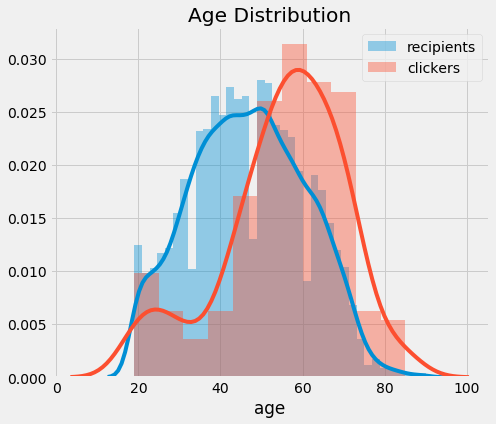

In [340]:
#Distribution plot for age between Receivers and Clickers

plt.figure(figsize=(7,6))
sns.distplot(dfSends.age, label = "recipients")
sns.distplot(dfSends[dfSends['click'] == True].age, label = "clickers");
plt.legend()
plt.title("Age Distribution")

- From the plot, we can see that the Clickers distribution is shifting to the right panel, which means older age group
- Average age of Recipients are 47, while Clickers are 55

Text(0, 0.5, 'Count')

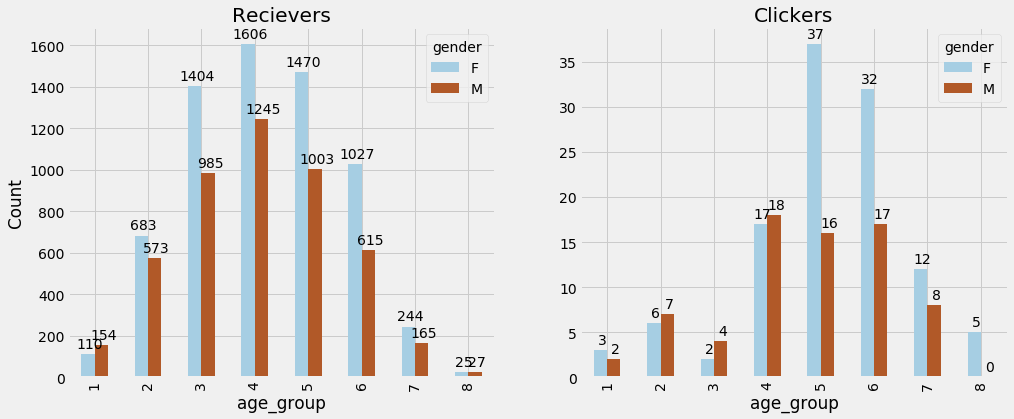

In [345]:
#Use figure with subplots

fig, axs = plt.subplots(ncols=2, figsize=(15, 6))
plt.style.use('fivethirtyeight')
bins = np.arange(10, 100, 10)
dfSends['age_group'] = np.digitize(dfSends.age, bins, right=True)

# Plot1 with Recievers
counts1 = dfSends.groupby(['age_group', 'gender']).age.count().unstack()
ax1 = counts1.plot(kind='bar',stacked = False, colormap = 'Paired', ax=axs[0]);
for p in ax1.patches:
        ax1.annotate(np.round(p.get_height(),decimals=0).astype(np.int64), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(2, 10), textcoords='offset points')

# Plot2 with Clickers
counts2 = dfSends[dfSends['click']==True].groupby(['age_group', 'gender']).age.count().unstack()
ax2 = counts2.plot(kind='bar',stacked = False, colormap = 'Paired', ax=axs[1]);
for p in ax2.patches:
        ax2.annotate(np.round(p.get_height(),decimals=0).astype(np.int64), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(2, 10), textcoords='offset points')
        
ax1.set_title('Recievers')
ax2.set_title('Clickers')
ax1.set_ylabel('Count')

In [280]:
# Calculate subscribe rate

F_recipient = counts1['F'].sum()/(counts1.sum().sum())
print (F_recipient)
M_recipient = counts1['M'].sum()/(counts1.sum().sum())
print (M_recipient)

if (F_recipient > M_recipient):
    print ("Female recipients is higher than Male recipients rate")
recipient_difference_rate = F_recipient - M_recipient
print ("The difference betweem ammount of Female - Male Recipient is" ,recipient_difference_rate.round(1)*100,"%")

0.5794812985179958
0.4205187014820042
Female recipients is higher than Male recipients rate
The difference betweem ammount of Female - Male Recipient is 20.0 %


In [ ]:
def 

In [279]:
# Calculate click rate

F_clickrate = counts2['F'].sum() / (counts2.sum().sum()) 
print( F_clickrate)

M_clickrate = counts2['M'].sum() / (counts2.sum().sum()) 
print (M_clickrate)

if (F_clickrate > M_clickrate):
    print ("Female click rate is higher than Male click rate")

click_difference_rate = F_clickrate - M_clickrate
print ("That difference betweem amount of Female - Male Clickers is" ,click_difference_rate.round(1)*100,"%")

0.6129032258064516
0.3870967741935484
Female click rate is higher than Male click rate
That difference betweem amount of Female - Male Clickers is 20.0 %


In [264]:
#Summary of Clickers age 

dfSends[dfSends.click == True].age.describe()

count    186.000000
mean      55.344086
std       14.784210
min       19.000000
25%       48.000000
50%       57.500000
75%       66.000000
max       85.000000
Name: age, dtype: float64

In [267]:
#Summary of Recipients age

dfSends.age.describe()

count    11337.000000
mean        46.793655
std         13.944349
min         19.000000
25%         36.000000
50%         47.000000
75%         57.000000
max         90.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Female - Male ratio in our list')

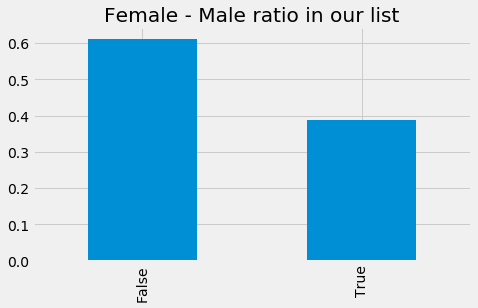

In [335]:
#Female-Male ratio

dfSends[dfSends['click'] == True].male.value_counts(normalize=True).plot(kind='bar', figsize=(7,4))
plt.title('Female - Male ratio in our list')

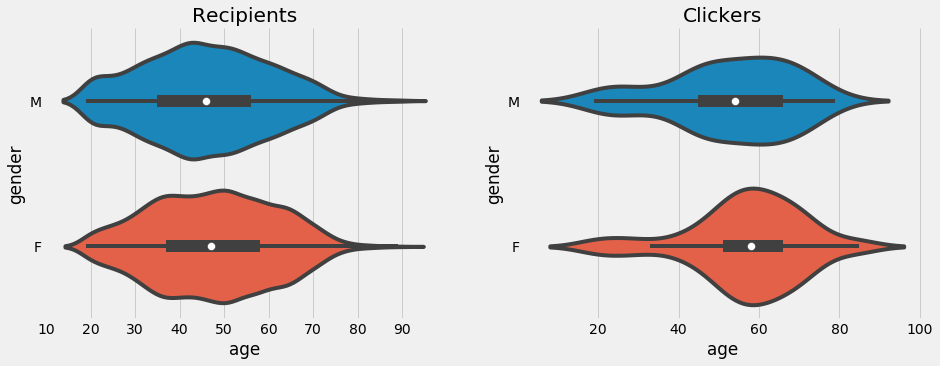

In [333]:
#Try with violinplot

fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
sns.violinplot(dfSends.age, dfSends.gender, ax=axs[0]).set_title('Recipients')
sns.violinplot(dfSends[dfSends['click']==True].age, dfSends[dfSends['click']==True].gender, ax=axs[1]).set_title('Clickers')
sns.despine()

### Discussion

From those two violin plots, we can see that :
- The range of high frequent Clickers from both gender is in Middle Age (40-80)
- Age group (40-80) might have more free time to read email, low awereness before clicking a link
- Teen Age group (10-20) and Elder (80-90) have lowest subscribe + click rate due to low internet surfing time in their normal day
- The trend of Age distribution from Recievers to Clickers is shifting to the right panel, which mean more older age group is clicking the links
- The difference rate between gender is keeping same proportion from Recievers(before Campaign) to Clickers(after Campaign), which is still  60% Female and 40% Male. We can assume that Female and Male users interract the same, with this campaign send out.